In [1]:
import tensorflow as tf
tf.enable_eager_execution()

/Users/totucuong/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
tfe = tf.contrib.eager

In [3]:
from math import pi

def f(x):
    return tf.square(tf.sin(x))

In [5]:
assert (f(pi/2).numpy() == 1.0)

In [7]:
f(pi).numpy()

7.642742e-15

In [11]:
grad_f = tfe.gradients_function(f)

In [13]:
assert tf.abs(grad_f(pi/2)[0]).numpy() < 1e-7


In [28]:
def f(x):
  return tf.square(tf.sin(x))

def grad(f):
  return lambda x: tfe.gradients_function(f)(x)[0]

x = tf.lin_space(-2*pi, 2*pi, 100)  

In [29]:
%matplotlib inline

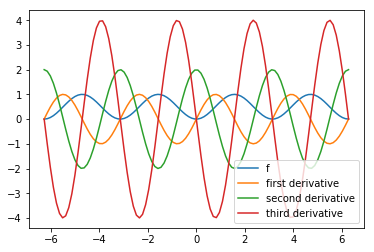

In [30]:
import matplotlib.pyplot as plt

plt.plot(x, f(x), label="f")
plt.plot(x, grad(f)(x), label="first derivative")
plt.plot(x, grad(grad(f))(x), label="second derivative")
plt.plot(x, grad(grad(grad(f)))(x), label="third derivative")
plt.legend()
plt.show()

In [46]:
def f(x, y):
  return x * x * x * y - x * y * y


In [47]:
grad_fn = tfe.gradients_function(f)

In [49]:
grad_fn(2.0,3.0)

[<tf.Tensor: id=1706, shape=(), dtype=float32, numpy=27.0>,
 <tf.Tensor: id=1707, shape=(), dtype=float32, numpy=-4.0>]

In [64]:
gradgrad_fn = tfe.gradients_function(lambda x, y: grad_fn(x, y)[1])


In [65]:
gradgrad_fn(2.0, 3.0)

[<tf.Tensor: id=1986, shape=(), dtype=float32, numpy=6.0>,
 <tf.Tensor: id=1987, shape=(), dtype=float32, numpy=-4.0>]

In [53]:
lambda x,y :grad_fn(x,y)[0]

<function __main__.<lambda>(x, y)>

In [39]:
tfe.gradients_function?

Signature: tfe.gradients_function(f, params=None)
Docstring:
Returns a function which differentiates f with respect to params.

Example:
```python
# f(x, y) = (x ^ 3) * y - x * (y ^ 2)
# Therefore, the 1st order derivatives are:
#   df / dx = 3 * (x ^ 2) * y - y ^ 2
#   df / dy = x ^ 3 - 2 * x * y
# The 2nd order derivatives with respect to x is:
#   d^2 f / (dx)^2 = 6 * x * y
def f(x, y):
  return x * x * x * y - x * y * y

# Obtain a function that returns 1st order gradients.
grad_fn = tfe.gradients_function(f)

x = 2.0
y = 3.0

# Invoke the 1st order gradient function.
x_grad, y_grad = grad_fn(x, y)
assert x_grad.numpy() == 3 * (2 ** 2) * 3 - 3 ** 2
assert y_grad.numpy() == (2 ** 3) - 2 * 2 * 3

# Obtain a function that returns the 2nd order gradient with respect to x.
gradgrad_fn = tfe.gradients_function(lambda x, y: grad_fn(x, y)[0])

# Invoke the 2nd order gradient function.
x_gradgrad = gradgrad_fn(x, y)[0]
assert x_gradgrad.numpy() == 6 * 2 * 3

# To obtain a callable that retu

In [66]:
def f(x, y):
  output = 1
  # Must use range(int(y)) instead of range(y) in Python 3 when
  # using TensorFlow 1.10 and earlier. Can use range(y) in 1.11+
  for i in range(int(y)):
    output = tf.multiply(output, x)
  return output

def g(x, y):
  # Return the gradient of `f` with respect to it's first parameter
  return tfe.gradients_function(f)(x, y)[0]

assert f(3.0, 2).numpy() == 9.0   # f(x, 2) is essentially x * x
assert g(3.0, 2).numpy() == 6.0   # And its gradient will be 2 * x
assert f(4.0, 3).numpy() == 64.0  # f(x, 3) is essentially x * x * x
assert g(4.0, 3).numpy() == 48.0  # And its gradient will be 3 * x * x

In [70]:
x = tf.ones((2, 2))
    
# a single t.gradient() call when the bug is resolved.
with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = tf.multiply(y, y)

# Use the same tape to compute the derivative of z with respect to the
# intermediate value y.
dz_dy = t.gradient(z, y)
assert dz_dy.numpy() == 8.0

# Derivative of z with respect to the original input tensor x
dz_dx = t.gradient(z, x)
for i in [0, 1]:
    for j in [0, 1]:
        assert dz_dx[i][j].numpy() == 8.0

In [69]:
dz_dy

<tf.Tensor: id=2035, shape=(), dtype=float32, numpy=-1.5258789e-05>

In [71]:
t.gradient()

TypeError: gradient() missing 2 required positional arguments: 'target' and 'sources'